# Lab 6: North Carolina 

In [7]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [8]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1: Population Growth Rate

In [17]:
sql = """
  SELECT year, pop
FROM population
WHERE fips = '37'
ORDER BY year ASC;
     """

In [19]:
import pandas as pd

q1_df = pd.read_sql(sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_7784/893980231.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(sql, con=conn)


,year,pop
0,2005,8411041
1,2006,8856505
2,2007,9061032
3,2008,9222414
4,2009,9380884


In [23]:
# Calculate year-over-year growth rate (%)
q1_df['growth_rate'] = q1_df['pop'].pct_change() * 100

# Drop the first row (since it has no previous year for comparison)
q1_df = q1_df.dropna()

q1_df.head()

,year,pop,growth_rate
1,2006,8856505,5.296182
2,2007,9061032,2.309342
3,2008,9222414,1.781055
4,2009,9380884,1.718314
5,2010,9561558,1.925981


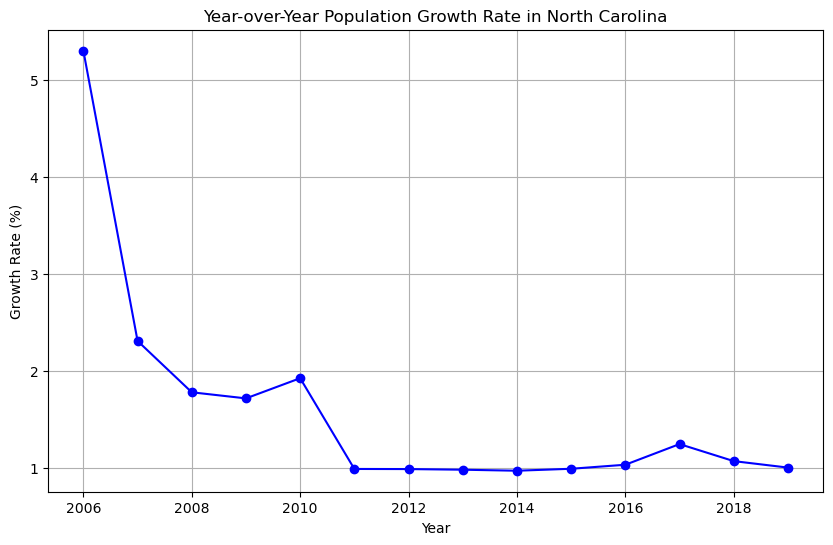

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(q1_df['year'], q1_df['growth_rate'], marker='o', linestyle='-', color='blue')

# Title must include state name (per lab instructions)
plt.title("Year-over-Year Population Growth Rate in North Carolina")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.show()

The line chart shows how North Carolina’s population growth changed year by year. Periods with higher peaks reflect rapid growth, while lower points represent slower growth. I pulled North Carolina's population data from PostgresSQL into a pandas DataFrame. From there, I caculated the population growth rate, year-over-year, in Python code. After, I plotted the growth rate in line graph format, presented above.

## Q2: Income and Population Relationship

In [12]:
q2_sql = """
SELECT
    p.year,
    p.pop AS population,
    i.income
FROM population p
JOIN income i
    ON p.fips = i.fips
    AND p.year = i.year
WHERE p.fips = '37'
ORDER BY p.year ASC;
"""

In [13]:

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_6933/3723254887.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,year,population,income
0,2005,8411041,40729
1,2006,8856505,42625
2,2007,9061032,44670
3,2008,9222414,46549
4,2009,9380884,43674


In [15]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [16]:
 pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [21]:
%load_ext jupyter_ai_magics

In [26]:
%%ai gpt4 -f code
use the data in dataframe {q2_df},visualization: create a dual-axis chart in Python with Jupyter AI’s help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name North Carolina in the title.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the given dataset in a DataFrame df
df = pd.DataFrame({'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                   'population': [8411041, 8856505, 9061032, 9222414, 9380884, 9561558, 9656401, 9752073, 9848060, 9943964, 10042802, 10146788, 10273419, 10383620, 10488084], 
                   'income': [40729, 42625, 44670, 46549, 43674, 43326, 43916, 45150, 45906, 46556, 47830, 50584, 52752, 53855, 57341]})

fig, ax1 = plt.subplots()

# Define population line
ax1.plot(df['year'], df['population'], color='tab:blue')
ax1.set_xlabel('year')
ax1.set_ylabel('population', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

# Define income line
ax2.plot(df['year'], df['income'], color='tab:red')
ax2.set_ylabel('income', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title
plt.title('Population and Median Household Income in North Carolina (2005-2019)')

# Display the figure
plt.show()

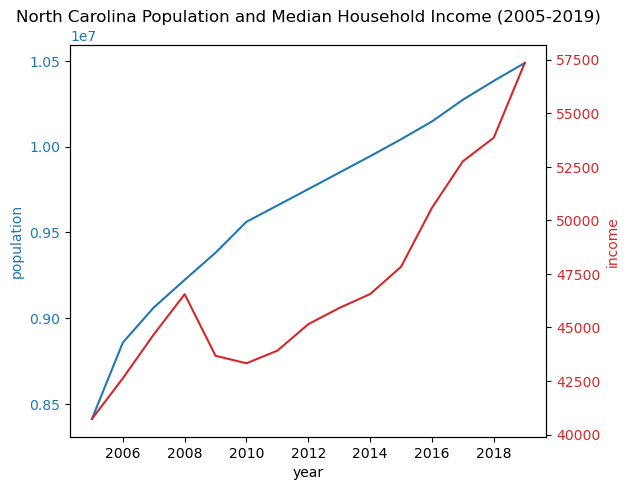

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the given dataset in a DataFrame df
df = pd.DataFrame({'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                   'population': [8411041, 8856505, 9061032, 9222414, 9380884, 9561558, 9656401, 9752073, 9848060, 9943964, 10042802, 10146788, 10273419, 10383620, 10488084], 
                   'income': [40729, 42625, 44670, 46549, 43674, 43326, 43916, 45150, 45906, 46556, 47830, 50584, 52752, 53855, 57341]})

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('year')
ax1.set_ylabel('population', color=color)
ax1.plot(df['year'], df['population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('income', color=color)
ax2.plot(df['year'], df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('North Carolina Population and Median Household Income (2005-2019)')
plt.show()

The graph above shows the population and median household income trends in North Carolina from 2005 to 2019
Based on the information above, it suggests that North carolina experienced both population expansion and economic imporvement during this time.

## Q3: Median Household Income Growth

In [33]:
# Make sure pandas is imported
import pandas as pd

# Select only the year and income columns
income_table = df[['year', 'income']].copy()

# Rename columns for readability
income_table.columns = ['Year', 'Median Household Income ($)']

# Format the income values with commas and dollar signs
income_table['Median Household Income ($)'] = income_table['Median Household Income ($)'].map('${:,.0f}'.format)

# Display the table neatly
display(
    income_table.style.hide(axis='index').set_caption(
        "Median Household Income in North Carolina (2005–2019)"
    )
)

Year,Median Household Income ($)
2005,"$40,729"
2006,"$42,625"
2007,"$44,670"
2008,"$46,549"
2009,"$43,674"
2010,"$43,326"
2011,"$43,916"
2012,"$45,150"
2013,"$45,906"
2014,"$46,556"


In [38]:
%%ai gpt4 -f code
use the data in dataframe {income_table},visualization: 

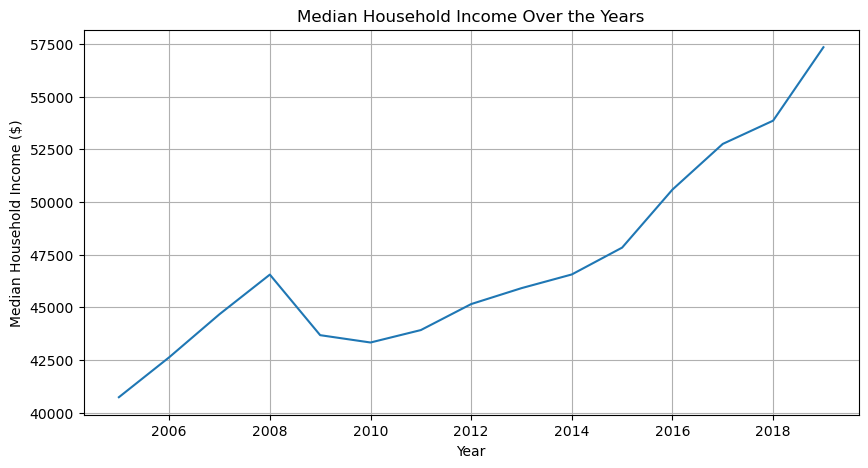

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize DataFrame
df = pd.DataFrame({'Year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                   'Median Household Income ($)': ['$40,729', '$42,625', '$44,670', '$46,549', '$43,674', '$43,326', '$43,916', '$45,150', '$45,906', '$46,556', '$47,830', '$50,584', '$52,752', '$53,855', '$57,341']})

# Clean the data
df['Median Household Income ($)'] = df['Median Household Income ($)'].replace('[\$,]', '' , regex=True).astype(int)

# Plot the data
plt.figure(figsize=(10,5))
plt.plot(df['Year'], df['Median Household Income ($)'])
plt.title('Median Household Income Over the Years')
plt.xlabel('Year')
plt.ylabel('Median Household Income ($)')
plt.grid(True)
plt.show()

The graph above shows the median household income from 2005 to 2019. The information above can be used to depict small, local economic reccessions in the North Carolina region in certain years. In general, the area has had notable economic imporvement since 